## Laboratorio 02

Construir un MLP, con pytorch, considerando lo siguiente:

1. El MLP, debe servir para realizar clasificaciones de al menos 5 clases o tipos de difentes ambitos.
2. El MLP debe contener al menos 50 unidades  neuronales en una capa oculta.
3. Se debe entrenar por almenos 1000 epochs y explicar que sucede en este proceso.
4. Se debe implementar un mecanismo de checkpoints para el proceso de entrenamiento que permita respaldar los valores calculados para los parametros, cada 20 epochs.
5. Aplicar las formas (frameworks) de exportación de modelos Torchscript y ONNX, a traves de ejemplos.
6. El dataset debe cumplir con: n >= 10, m >= 10000 y Numero de clases >= 5.
7. Se debe coordinar entre estudiantes para evitar que dos o mas estudiantes utilizen el mismo dataset.
8. Utilizar de manera obligatoria objetos dataset y dataloader en la implementacion.
9. Se debe aplicar las tecnicas de normalizacion, optimizacion y buenas practicas para lograr el menor valor de costo y el mayor valor de precision.
Se debe subir todo a un repositorio el cual debes ser compartido, ademas de subir todos los cuadernillos o codigo fuente generados.

Este cuaderno implementa un Perceptrón Multicapa (MLP) en PyTorch para la clasificación de imágenes en el dataset FashionMNIST. Se incluyen:
- Preprocesamiento de datos con `Dataset` y `DataLoader`
- Definición del modelo con una capa oculta de al menos 50 neuronas
- Entrenamiento con 1000 épocas y checkpoints cada 20 épocas


##Creando la conexion con el dataset


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Instalar unrar para descompirmir los archivos .rar
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [7]:
dataset_path = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset03/Dataset_lab3.rar"

In [9]:
!unrar x "/content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset03/Dataset_lab3.rar" "/content/dataset/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/SIS421/Laboratorios/Datasets/Dataset03/Dataset_lab3.rar

Creating    /content/dataset                                          OK
Creating    /content/dataset/Dataset_lab3                             OK
Creating    /content/dataset/Dataset_lab3/Clavel_estrella             OK
Extracting  /content/dataset/Dataset_lab3/Clavel_estrella/clavel_estrella_0.jpg       0%  OK 
Extracting  /content/dataset/Dataset_lab3/Clavel_estrella/clavel_estrella_1.jpg       0%  OK 
Extracting  /content/dataset/Dataset_lab3/Clavel_estrella/clavel_estrella_10.jpg       0%  OK 
Extracting  /content/dataset/Dataset_lab3/Clavel_estrella/clavel_estrella_100.jpg       0%  OK 
Extracting  /content/dataset/Dataset_lab3/Clavel_estrella/clavel_estrella_101.jpg       0%  OK 
Extracting  /content/dataset/Dataset_lab3/Clavel_estrella/clavel_estrella_102.jpg     

In [17]:
%cd /content/dataset/Dataset_lab3
!ls Clavel_estrella/ | wc -l
!ls Rafines/ | wc -l
!ls Matricaria_Tetra_Blanca/ | wc -l
!ls Montecasino/ | wc -l
!ls Flor_alfa/ | wc -l

/content/dataset/Dataset_lab3
500
500
500
500
500


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os


## Configuracion de hiperparámetros

In [53]:
BATCH_SIZE = 64
EPOCHS = 1000
LEARNING_RATE = 0.001
CHECKPOINT_INTERVAL = 20

#Mostrar Datos

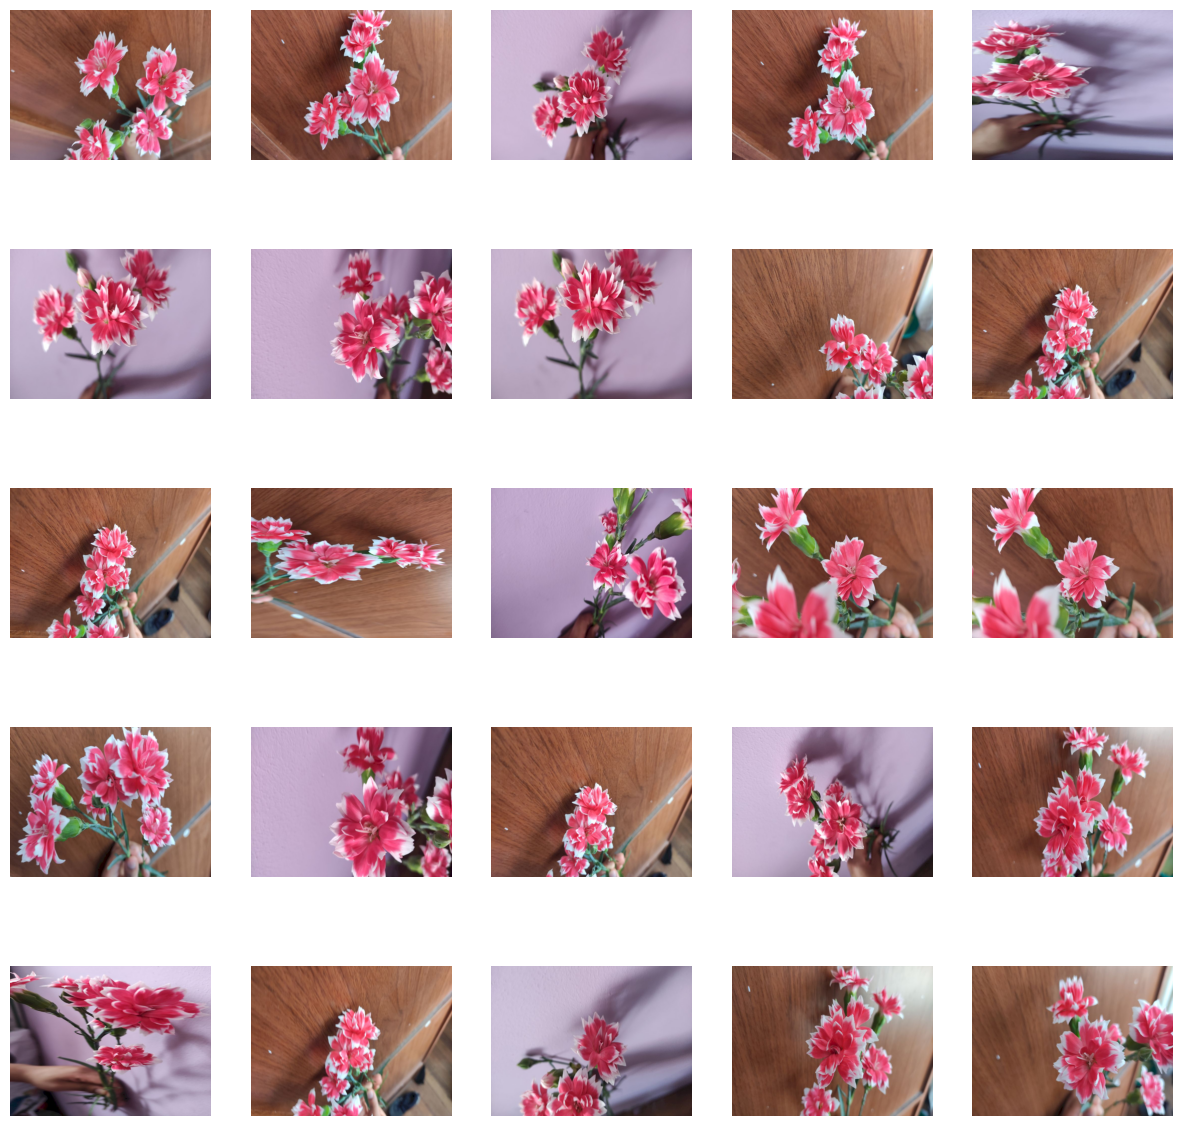

In [18]:
#mostramos imagenes

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


plt.figure(figsize=(15,15))

carpeta = '/content/dataset/Dataset_lab3/Clavel_estrella'
imagenes = os.listdir(carpeta)

for i, nombreimg in  enumerate(imagenes[0:25]):
  plt.subplot(5,5,i+1)
  img = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(img)
  plt.axis('off')

In [20]:
import os
import shutil

# Directorios originales (reemplázalos con las rutas correctas)
origenes = {
    "clavelEstrella": "/content/dataset/Dataset_lab3/Clavel_estrella",
    "rafines": "/content/dataset/Dataset_lab3/Rafines",
    "matricariaTetraBlanca": "/content/dataset/Dataset_lab3/Matricaria_Tetra_Blanca",
    "monteCasino": "/content/dataset/Dataset_lab3/Montecasino",
    "florAlfa": "/content/dataset/Dataset_lab3/Flor_alfa"
}

# Directorio de destino
destino_base = "dataset_organizado"

# Crear estructura de carpetas
os.makedirs(destino_base, exist_ok=True)
for clase in origenes.keys():
    os.makedirs(os.path.join(destino_base, clase), exist_ok=True)

# Mover imágenes a la estructura nueva
for clase, origen in origenes.items():
    destino = os.path.join(destino_base, clase)
    for archivo in os.listdir(origen):
        if archivo.endswith(('.jpg', '.png', '.jpeg')):  # Filtrar solo imágenes
            shutil.copy(os.path.join(origen, archivo), os.path.join(destino, archivo))

print("Dataset organizado correctamente en:", destino_base)

Dataset organizado correctamente en: dataset_organizado


In [21]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directorio del dataset organizado
dataset_path = "dataset_organizado"
train_path = "dataset_organizado/train"
test_path = "dataset_organizado/test"

# Crear carpetas de entrenamiento y prueba
for split in [train_path, test_path]:
    os.makedirs(split, exist_ok=True)

# Proporción de entrenamiento y prueba
split_ratio = 0.8  # 80% train, 20% test

# Recorrer las clases y dividirlas
for clase in os.listdir(dataset_path):
    clase_path = os.path.join(dataset_path, clase)

    # Ignorar directorios de train/test si ya existen
    if clase in ["train", "test"]:
        continue

    # Crear carpetas para la clase en train y test
    os.makedirs(os.path.join(train_path, clase), exist_ok=True)
    os.makedirs(os.path.join(test_path, clase), exist_ok=True)

    # Obtener lista de imágenes
    imagenes = [f for f in os.listdir(clase_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Dividir en train y test
    train_imgs, test_imgs = train_test_split(imagenes, train_size=split_ratio, random_state=42)

    # Mover imágenes
    for img in train_imgs:
        shutil.move(os.path.join(clase_path, img), os.path.join(train_path, clase, img))
    for img in test_imgs:
        shutil.move(os.path.join(clase_path, img), os.path.join(test_path, clase, img))

print("División del dataset completada.")


División del dataset completada.


##Tansformaciones y carga de datos

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar las imágenes al tamaño estadndar
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Normalizacion de pixeles de cada color y desviacion standar
])

# Cargar los datasets de entrenamiento y prueba desde las carpetas correspondientes
train_dataset = datasets.ImageFolder(root='./dataset_organizado/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./dataset_organizado/test', transform=transform)

# Crear los DataLoaders para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Obtener las clases del dataset
classes = train_dataset.classes
num_classes = len(classes)
print(f"Clases en el dataset: {classes}")


Clases en el dataset: ['clavelEstrella', 'florAlfa', 'matricariaTetraBlanca', 'monteCasino', 'rafines']


##Definición del modelo MLP

In [42]:
# Definición del MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 50)  # Capa oculta con 50 neuronas
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 5)  # 5 Clases de flores

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

##Inicializacion del modelo, función de pérdida y optimizador

In [43]:
# Inicialización del modelo
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

##Función de entrenamiento con checkpoints

In [56]:
# Función de entrenamiento con checkpoints
def train_model():
    os.makedirs("checkpoints", exist_ok=True)
    CHECKPOINT_DIR = "/content/drive/MyDrive/SIS421/Laboratorios/Datasets"
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

        if epoch % CHECKPOINT_INTERVAL == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"mlp_epoch_{epoch}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint guardado en epoch {epoch}")

##Entrenando Modelo

In [57]:
# Ejecutar entrenamiento
train_model()

Epoch 1/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 2/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 3/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 4/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 5/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 6/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 7/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 8/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 9/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 10/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 11/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 12/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 13/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 14/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 15/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 16/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 17/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 18/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 19/1000, Loss: 0.0008, Accuracy: 100.00%
Epoch 20/1000, Loss: 0.0008, Accuracy: 100.00%
Checkpoint guardado en epoch 20
Epoch 21/1000, Loss: 0.0008, Accuracy

##Evaluando Modelo

In [46]:
# Evaluación
# -----------------------
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

# Calcular métricas promedio
val_acc = 100 * val_correct / val_total
val_loss_avg = val_loss / len(test_loader)

# Imprimir resultados de evaluación
print(f"📊 Evaluación del modelo:")
print(f"🔹 Pérdida promedio (loss): {val_loss_avg:.4f}")
print(f"🔹 Precisión (accuracy): {val_acc:.2f}%")

📊 Evaluación del modelo:
🔹 Pérdida promedio (loss): 0.0119
🔹 Precisión (accuracy): 99.60%


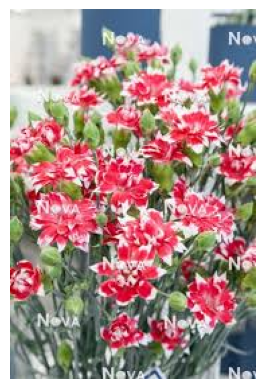

Predicción: clavelEstrella


In [37]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir las transformaciones para las imágenes reales
transform = transforms.Compose([
    transforms.Resize((32,32)), # Redimensionar a 32x32
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
])


image_path = '/content/florPrueba/flor1.jpeg'
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()


image = transform(image).unsqueeze(0)
image = image.to(device)

model.eval()

# Realizar la predicción
with torch.no_grad():
    outputs = model(image)

_, predicted_class = torch.max(outputs, 1)

# Mostrar la clase predicha
predicted_label = train_dataset.classes[predicted_class.item()]
print(f"Predicción: {predicted_label}")

##Torchscrypt y ONNX

In [47]:
# Cargar el modelo entrenado
model = MLP()
model.load_state_dict(torch.load("/content/dataset/Dataset_lab3/checkpoints/mlp_epoch_10.pth", map_location=torch.device('cpu')))
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)

In [48]:
# Exportar con trazado
example_input = torch.randn(1, 3, 32, 32)  # input con el mismo tamaño que entrenaste
traced_script_module = torch.jit.trace(model, example_input)

# Guardar el archivo TorchScript
traced_script_module.save("mlp_model_scripted.pt")
print("✅ Modelo exportado como TorchScript: mlp_model_scripted.pt")

✅ Modelo exportado como TorchScript: mlp_model_scripted.pt


In [51]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 40.2 MB/s eta 0:00:00


In [52]:
# Exportar a ONNX

onnx_path = "mlp_model.onnx"
torch.onnx.export(
    model,                      # El modelo
    example_input,              # Un input dummy
    onnx_path,                  # Ruta de salida
    input_names=["input"],      # Nombre de la entrada
    output_names=["output"],    # Nombre de la salida
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11            # Versión de ONNX (puedes ajustar si lo necesitas)
)
print("✅ Modelo exportado como ONNX: mlp_model.onnx")

✅ Modelo exportado como ONNX: mlp_model.onnx
